# Neural Machine Translation

In this notebook we will implement a small transformer model for machine translation task. Our model would be able to translate human readabke dates in any format to YYYY-MM-DD format.

We will be using `faker` module to generate our dataset

In [1]:
%%capture
!pip install -q faker

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re, random

from faker import Faker
from babel.dates import format_date

pd.options.display.max_colwidth = None
sns.set_style('darkgrid')

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import losses, callbacks, utils, models, Input
from tensorflow.keras import layers as L

# Data Generation

In [4]:
# Constants
class config():  
    SAMPLE_SIZE = 10_00_000        
    DATE_FORMATS = [
        'short', 'medium', 'long', 'full',
        'd MMM YYY', 'd MMMM YYY', 'dd/MM/YYY',
        'EE d, MMM YYY', 'EEEE d, MMMM YYY', 'd of MMMM YYY',
    ]
    VALIDATION_SIZE = 0.1
    BATCH_SIZE = 32
    MAX_EPOCHS = 25
    EMBED_DIM = 16
    DENSE_DIM = 16
    NUM_HEADS = 2
    X_LEN = 30
    Y_LEN = 14
    NUM_ENCODER_TOKENS = 35
    NUM_DECODER_TOKENS = 14

In [5]:
faker = Faker()
print('Sample dates for each format\n')

for fmt in set(config.DATE_FORMATS):
    print(f'{fmt:20} =>  {format_date(faker.date_object(), format=fmt, locale="en")}')

Sample dates for each format

d of MMMM YYY        =>  1 of March 1996
d MMM YYY            =>  7 Apr 2014
short                =>  9/6/20
medium               =>  Jan 23, 1997
dd/MM/YYY            =>  01/12/1987
d MMMM YYY           =>  7 August 1994
long                 =>  August 13, 2018
full                 =>  Wednesday, January 23, 1974
EE d, MMM YYY        =>  Tue 11, Oct 2005
EEEE d, MMMM YYY     =>  Thursday 12, May 2011


In [6]:
# a utility data cleaning function
def clean_date(raw_date):
    return raw_date.lower().replace(',', '')

# this function will generate our data in a data frame
def create_dataset(num_rows):
    dataset = []
    
    for i in tqdm(range(num_rows)):
        dt = faker.date_object()
        for fmt in config.DATE_FORMATS:
            try:
                date = format_date(dt, format=fmt, locale='en')
                human_readable = clean_date(date)
                machine_readable = f"@{dt.isoformat()}#" # adding a start token '@' and end token '#'
            except AttributeError as e:
                date = None
                human_readable = None
                machine_readable = None
            if human_readable is not None and machine_readable is not None:
                dataset.append((human_readable, machine_readable))
 
    return pd.DataFrame(dataset, columns=['human_readable', 'machine_readable'])

In [7]:
# generate the dataset using the function defined above
dataset = create_dataset(config.SAMPLE_SIZE)
dataset  = dataset.drop_duplicates(subset=['human_readable']).sample(frac=1.0).reset_index(drop=True)
print(dataset.shape)
dataset.head()

  0%|          | 0/1000000 [00:00<?, ?it/s]

(187584, 2)


,human_readable,machine_readable
0,sunday 24 july 1977,@1977-07-24#
1,wed 26 oct 1988,@1988-10-26#
2,7 mar 1989,@1989-03-07#
3,4 july 2005,@2005-07-04#
4,21 december 1975,@1975-12-21#


**Define tokenizers for both the languages (human readable and machine readable dates)**

In [8]:
human_tokenizer = Tokenizer(char_level=True)
machine_tokenizer = Tokenizer(char_level=True)

human_tokenizer.fit_on_texts(dataset['human_readable'].values)
machine_tokenizer.fit_on_texts(dataset['machine_readable'].values)

print(human_tokenizer.word_index)
print(machine_tokenizer.word_index)

{' ': 1, '1': 2, '2': 3, '9': 4, '0': 5, 'a': 6, 'e': 7, 'r': 8, 'u': 9, '/': 10, '8': 11, '7': 12, 'y': 13, 'o': 14, 'n': 15, 'd': 16, 'm': 17, 't': 18, 's': 19, '3': 20, 'b': 21, '5': 22, '4': 23, '6': 24, 'f': 25, 'j': 26, 'c': 27, 'p': 28, 'l': 29, 'h': 30, 'i': 31, 'g': 32, 'v': 33, 'w': 34}
{'-': 1, '0': 2, '1': 3, '2': 4, '9': 5, '@': 6, '#': 7, '8': 8, '7': 9, '3': 10, '4': 11, '6': 12, '5': 13}


In [9]:
# A utility function to clean and tokenize the text and then pad the sequence
def preprocess_input(date, tokenizer, max_len):
    seq = [i[0] for i in tokenizer.texts_to_sequences(date.lower().replace(',', ''))]
    seq = pad_sequences([seq], padding='post', maxlen=max_len)[0]
    return seq

**Preprocessing the data**

In [10]:
%%time

X = np.array(list(map(lambda x: preprocess_input(x, human_tokenizer, config.X_LEN), dataset['human_readable'])))
y = np.array(list(map(lambda x: preprocess_input(x, machine_tokenizer, config.Y_LEN), dataset['machine_readable'])))

X.shape, y.shape

CPU times: user 14.3 s, sys: 226 ms, total: 14.5 s
Wall time: 14.2 s


((187584, 30), (187584, 14))

In [11]:
# Cross Validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=config.VALIDATION_SIZE, random_state=19)

A utility function to generate batches of data
* encoder input data would be source language text
* decoder input data would be target language text
* decoder output data would be target language text shifted one time stamp forward (one hot encoded)

In [12]:
def generate_batch(X, y, batch_size=config.BATCH_SIZE):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = X[j:j+batch_size]
            decoder_input_data = y[j:j+batch_size]
            output = y[j:j+batch_size]
            decoder_output_data = np.zeros_like(output)
            decoder_output_data[:,:-1] = output[:, 1:]
            decoder_target_data = utils.to_categorical(decoder_output_data, num_classes=config.NUM_DECODER_TOKENS)
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# Model

Let's define the key components for our model
* Positional Embedding Layer
* Encoder Block
* Decoder Block

In [13]:
class PositionalEmbedding(L.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = L.Embedding(input_dim, output_dim)
        self.position_embeddings = L.Embedding(sequence_length, output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config
    
class TransformerEncoder(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([L.Dense(dense_dim, activation='relu'), L.Dense(embed_dim)])
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_confog()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config    
    
class TransformerDecoder(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([
            L.Dense(dense_dim, activation='relu'), L.Dense(embed_dim)
        ])
        self.layernorm_1 = L.LayerNormalization()
        self.layernorm_2 = L.LayerNormalization()
        self.layernorm_3 = L.LayerNormalization()
        self.support_masking = False
        
    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
    
    def call(self, inputs, encoder_outputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=None
        )
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1, value=encoder_outputs, key=encoder_outputs, attention_mask=None
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2
        )
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

Lets Define our model

* Positional Embedding is applied to Encoder Inputs
* Embedded Encoder Inputs are fed to the Transformer Encoder
* Positional Embedding is applied to Decoder Inputs 
* Encoder Outputs and along with the Embedded Decoder Inputs are fed to the transformer Decoder
* We optionally apply dropout to the outputs from the decoder block before feeding it to the output layer

2022-04-19 17:02:26.614847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 17:02:26.709857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 17:02:26.710575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 17:02:26.711692: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
human (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
machine (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
positional_embedding (Positiona (None, None, 16)     1040        human[0][0]                      
__________________________________________________________________________________________________
positional_embedding_1 (Positio (None, None, 16)     448         machine[0][0]                    
______________________________________________________________________________________________

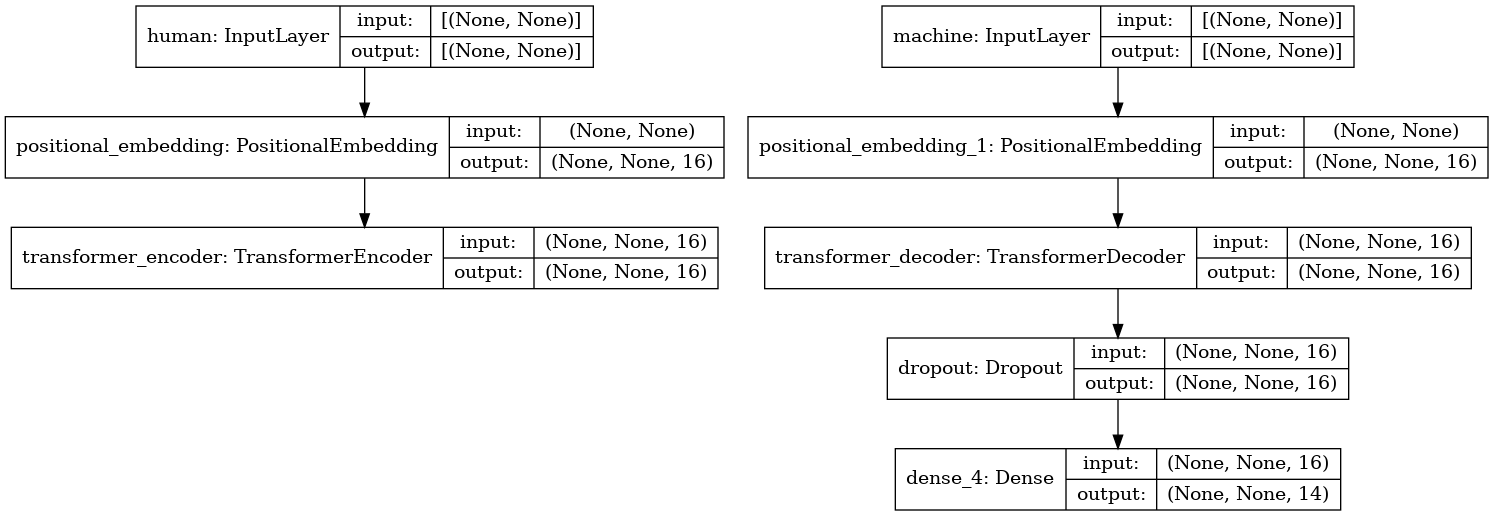

In [14]:
encoder_inputs = keras.Input(shape=(None, ), dtype="int64", name="human")
x = PositionalEmbedding(config.X_LEN, config.NUM_ENCODER_TOKENS, config.EMBED_DIM)(encoder_inputs)
encoder_outputs = TransformerEncoder(config.EMBED_DIM, config.DENSE_DIM, config.NUM_HEADS)(x)

decoder_inputs = keras.Input(shape=(None, ), dtype="int64", name="machine" )
x = PositionalEmbedding(config.Y_LEN, config.NUM_DECODER_TOKENS, config.EMBED_DIM)(decoder_inputs)
x = TransformerDecoder(config.EMBED_DIM, config.DENSE_DIM, config.NUM_HEADS)(x, encoder_outputs)
x = L.Dropout(0.5)(x)
decoder_outputs = L.Dense(config.NUM_DECODER_TOKENS, activation="softmax")(x)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
transformer.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")

transformer.summary()
utils.plot_model(transformer, show_shapes=True, expand_nested=True)

In [15]:
es = callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True, min_delta=1e-4)
rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)

In [16]:
%%capture training_log

history = transformer.fit(
    generate_batch(X_train, y_train), steps_per_epoch = np.ceil(len(X_train)/config.BATCH_SIZE),
    validation_data=generate_batch(X_valid, y_valid), validation_steps=np.ceil(len(X_valid)/config.BATCH_SIZE),
    epochs=config.MAX_EPOCHS, callbacks=[es, rlp], 
)

2022-04-19 17:02:30.246564: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-19 17:02:34.073265: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [17]:
with open('training.log', 'w') as f: f.write(training_log.stdout)

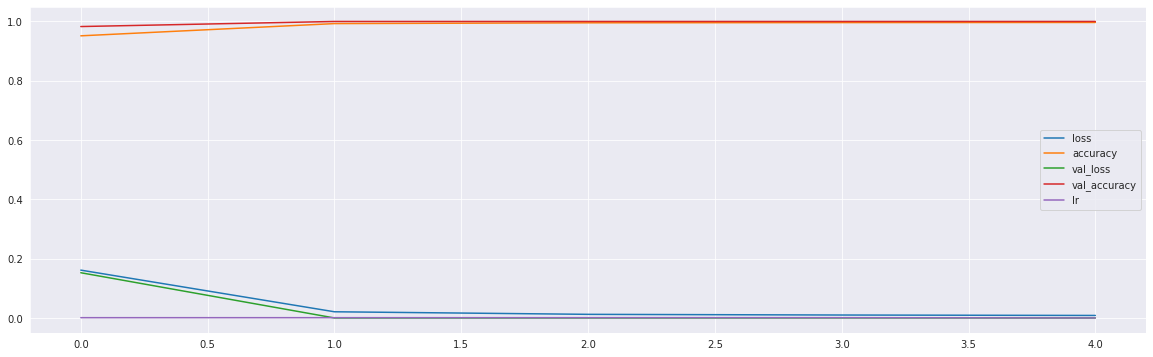

In [18]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).plot(ax=ax)
del history

# Evaluation

**Lets see our model in action**

In [19]:
# this function converts the token ids to token text
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return ""

# this function is used to generate predictions
# target sequence is intialised as the start token
# then predictions are taken from the model iteratively 
def predict_sequence(source):
    target_seq = "@"
    for i in range(14):
        tok_target_seq = preprocess_input(target_seq, machine_tokenizer, config.Y_LEN).reshape(1, -1)
        output_tokens = transformer.predict([source, tok_target_seq])
        token_index = np.argmax(output_tokens[0, i, :])
        token = word_for_id(token_index, machine_tokenizer)
        target_seq += token
        
    return target_seq

# this function decodes the complete sequence of token ids into text
def decode_sequence(tokenizer, source):
    target = list()
    for i in source:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ''.join(target)

In [20]:
query_text = 'saturday 19 september 1998'
query = np.array(list(map(lambda x: preprocess_input(x, human_tokenizer, config.X_LEN), [query_text])))
print('SOURCE     :', query_text)
print('PREDICTION :', predict_sequence(query))

SOURCE     : saturday 19 september 1998
PREDICTION : @6099-09-09#
